# Participez à la conception d'une voiture autonome

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2" # -1 for CPU
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import imageio
from collections import namedtuple
from timeit import default_timer as timer
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

sm.set_framework('tf.keras')
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

## Accès aux données

In [2]:
original_imgs_path = "./data/leftImg8bit"

cities = {"train":[dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "train"]))][0],
          "test": [dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "test"]))][0],
          "val": [dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "val"]))][0]}

df_file = f'./df.csv'

if not os.path.isfile(df_file):
    main_df = pd.DataFrame(columns=['split', 'original_image_path', 'labeled_image_path'])
    for split in ["train", "val"]:
        for city in cities[split]:
            tmp_path = "/".join([original_imgs_path, split, city])
            lbl_tmp_path = tmp_path.replace("leftImg8bit", "gtFine")
            for _, _, files in os.walk(tmp_path):
                for name in files:
                    if name.endswith(("_leftImg8bit.png")):
                        img_path = "/".join([tmp_path, name])
                        # tgt_img_path = "/".join([lbl_tmp_path, name]).replace("leftImg8bit", "gtFine_color")
                        tgt_img_path = "/".join([lbl_tmp_path, name]).replace("leftImg8bit", "gtFine_labelIds")
                        lbl_img_path = f"./data/labels/{name}".replace("leftImg8bit", "gtFine_labelIds")
                        main_df = main_df.append({"split": split,
                                                  "original_image_path": img_path,
                                                  "target_image_path": tgt_img_path,
                                                  "labeled_image_path": lbl_img_path,}, ignore_index=True)
    main_df.to_csv(df_file, index=False)
else:
    main_df = pd.read_csv(df_file)

In [3]:
Label = namedtuple('Label', ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color',])

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

id2cat = {label.id: label.categoryId for label in labels}

color_map = np.array([[0, 0, 0], # black: void
                      [153, 153, 0], # yellow: flat
                      [255, 204, 204], # light pink: construction
                      [255, 0, 127], # strong pink: object
                      [0, 255, 0], # green: nature
                      [0, 204, 204], # light blue: sky
                      [255, 0, 0], # red: human
                      [0, 0, 255], # blue: vehicle
                     ])

def show_color(clr):
    pic = np.full((100, 100, 3), clr)
    plt.imshow(pic, interpolation='nearest')
    plt.show()

In [4]:
def preprocess(): # only keep the 8 main classes
    for pic_path, out_path in zip(main_df["target_image_path"].values, main_df["labeled_image_path"].values):
        lbl = imageio.imread(pic_path)
        get_cat = np.vectorize(lambda x: id2cat[x])
        lbl = get_cat(lbl)
        lbl = lbl.astype(np.uint8)
        imageio.imwrite(out_path, lbl)
        
# preprocess()

In [5]:
display_dim = (700, 350)

def display_imgs(img1, img2, img3=None):
    plt.imshow(img1)
    plt.show()
    img2 = color_map[img2]
    plt.imshow(img1)
    plt.imshow(img2, alpha=0.5)
    plt.show()
    if img3 is not None:
        img3 = color_map[img3]
        plt.imshow(img1)
        plt.imshow(img3, alpha=0.5)
        plt.show()

In [6]:
ia.seed(1)

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontal flip

        iaa.SomeOf((0, 2),
            [
                #iaa.PerspectiveTransform(scale=(0.003, 0.008)), # add perspective

                iaa.Affine( # zoom
                    scale=(1.0, 1.3),
                ),

                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # change alpha / lightness

                iaa.OneOf([ # add blur / noise
                    iaa.GaussianBlur((0.0, 1.8)),
                    iaa.AdditiveGaussianNoise(
                        loc=0, scale=(0.0, 0.02*255)),
                ]),

                iaa.OneOf([ # change brightess / contrast / saturation
                    iaa.AddToBrightness((-25, 25)),
                    iaa.AllChannelsCLAHE(clip_limit=(1)),
                    iaa.GammaContrast((0.75, 1.2)),
                    iaa.MultiplySaturation((0.65, 1.3)),
                ]),

            ],
            random_order=True
        ),

        iaa.Sometimes(0.2, iaa.CoarseDropout((0.03, 0.06), size_percent=(0.07, 0.1))),
    ],
    random_order=False
)
    
def py_augment(img, tgt):
    img = img.numpy()
    tgt = tgt.numpy()
    segmap = SegmentationMapsOnImage(tgt, shape=tgt.shape)
    img, tgt = seq(image=img, segmentation_maps=segmap)
    return img, tgt.get_arr()

## Modèles

### Préparation

In [7]:
train_df = main_df[main_df["split"]=="train"]
val_df = main_df[main_df["split"]=="val"]

In [8]:
n_epochs = 20 # 20

batch_size = 8

data_passes = 300 # 300

steps_per_epoch = (train_df.shape[0] * data_passes) // (batch_size * n_epochs)

AUTOTUNE = tf.data.AUTOTUNE

BUFFER_SIZE = 1000

print(f"Training with {steps_per_epoch} steps per epoch")

Training with 5578 steps per epoch


In [9]:
results_file = f'./results.csv'

if not os.path.isfile(results_file):
    results = pd.DataFrame(columns=['model_name', 'iou_score', 'time', 'loss'])
    results.to_csv(results_file, index=False)

def add_result(name, score, time, loss=None):
    result_df = pd.read_csv(results_file)
    result_df = result_df[result_df["model_name"] != name]
    result_df = result_df.append({"model_name": name, "iou_score": score, "time": time, "loss": loss}, ignore_index=True)
    result_df.to_csv(results_file, index=False)
    
def get_results():
    result_df = pd.read_csv(results_file)
    print(result_df.head(20))
    
def process_model(model, hist, name, time):
    history = pd.DataFrame(data=hist.history)
    model.save(f"./models/{name}.h5")
    model.save_weights(f'./models/{name}_weights.h5')
    history.to_csv(f'./models/{name}_history.csv', index=False)
    add_result(name,
               round(history.iloc[-1]["val_iou_score"], 4),
               time,
               round(history.iloc[-1]["val_loss"], 4))
    
def display_learning_curves(m_name, metric):
    hst = pd.read_csv(f'./models/{m_name}_history.csv')
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate([metric, 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()

In [10]:
size = (224, 224)

BACKBONE = 'resnet34'

preprocess_input = sm.get_preprocessing(BACKBONE)

def load_imgs(path1, path2, mode="original"):
    img1 = tf.io.read_file(path1)
    img1 = tf.io.decode_png(img1)
    img2 = tf.io.read_file(path2)
    img2 = tf.io.decode_png(img2)
    
    if mode == "crop" or mode == "augmented_crop":
        combined = tf.concat([img1, img2], axis=2)
        last_label_dim = tf.shape(img2)[-1]
        last_image_dim = tf.shape(img1)[-1]
        combined_crop = tf.image.random_crop(combined, size=tf.concat([size, [last_label_dim + last_image_dim]], axis=0))
        img1 = combined_crop[:, :, :last_image_dim]
        img2 = combined_crop[:, :, last_image_dim:]
        
        if mode == "augmented_crop":
            img1, img2 = tf.py_function(py_augment, inp=[img1, img2], Tout=[tf.uint8, tf.uint8])
            
    img1 = preprocess_input(img1)
    img1 = tf.cast(img1, tf.float32)
    img2 = tf.squeeze(img2, axis=-1)
    img2 = tf.one_hot(img2, 8, axis=-1)
    
    return img1, img2


def get_dataset(df, repeat=1, augment=0):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["original_image_path"].values,
         df["labeled_image_path"].values,)
        ).shuffle(BUFFER_SIZE)

    if augment:
        ds = ds.map(lambda x, y: load_imgs(x, y, "augmented_crop"), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: load_imgs(x, y, "crop"), num_parallel_calls=AUTOTUNE)
        
    if repeat:
        ds = ds.repeat()
        
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


def display_crop(): # does not work with preprocess_input()
    train_ds = get_dataset(train_df, augment=1)
    img, lbl = next(iter(train_ds))
    img = np.asarray(img[0], dtype=np.uint8)
    lbl = np.asarray(lbl[0])
    lbl = np.argmax(lbl, axis=2)
    lbl = np.expand_dims(lbl, axis=2)
    lbl = np.apply_along_axis(lambda x: color_map[x[0]] , -1, lbl)
    plt.imshow(img)
    plt.show()
    plt.imshow(lbl)
    plt.show()
    
val_ds = get_dataset(val_df, repeat=0)

In [11]:
def train_model(model, name, t_ds, v_ds):

    lr = tf.keras.optimizers.schedules.ExponentialDecay(
             initial_learning_rate=1e-2,
             decay_steps=10000,
             decay_rate=0.9)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=sm.losses.bce_jaccard_loss, # sm.losses.bce_jaccard_loss
        metrics=[sm.metrics.iou_score], # sm.metrics.iou_score
    )

    t0 = timer()

    hist = model.fit(t_ds,
                     epochs=n_epochs,
                     verbose=2,
                     validation_data=v_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    
    t1 = timer() - t0

    process_model(model, hist, name, t1)


In [12]:
def prediction_display(mdl, loc=0):
    print(val_df.iloc[loc]["original_image_path"])
    pred_ds = tf.data.Dataset.from_tensor_slices(
        ([val_df.iloc[loc]["original_image_path"]],
         [val_df.iloc[loc]["labeled_image_path"]],)
        ).shuffle(BUFFER_SIZE)
    pred_ds = pred_ds.map(load_imgs, num_parallel_calls=AUTOTUNE)
    pred_ds = pred_ds.batch(1)
    pred = mdl.predict(pred_ds)
    toimg = np.asarray(pred[0])
    img3 = np.argmax(toimg, axis=2)

    img1 = imageio.imread(val_df.iloc[loc]["original_image_path"])
    img2 = imageio.imread(val_df.iloc[loc]["labeled_image_path"])
    
    display_imgs(img1, img2, img3)

### Unet + Resnet34

#### Without augmentations

In [13]:
skip = 1

trained = 1

if not skip:
    
    model_name = "unet_resnet34"

    model = sm.Unet(BACKBONE, classes=8, input_shape=(None, None, 3), activation='softmax', encoder_weights=None)

    model.summary(line_length=120)

In [14]:
if not skip:

    if not trained:
        train_ds = get_dataset(train_df)
        train_model(model, model_name, train_ds, val_ds)
    else:
        model.load_weights(f"./models/{model_name}_weights.h5")

    display_learning_curves(model_name, "iou_score")

#### With augmentations

In [15]:
skip = 0

trained = 0

if not skip:

    model_name = "unet_resnet34_aug"

    model = sm.Unet(BACKBONE, classes=8, input_shape=(None, None, 3), activation='softmax', encoder_weights=None)

    model.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
data (InputLayer)                      [(None, None, None, 3)]    0                                                     
________________________________________________________________________________________________________________________
bn_data (BatchNormalization)           (None, None, None, 3)      9             data[0][0]                              
________________________________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)         (None, None, None, 3)      0             bn_data[0][0]                           
________________________________________________________________________________________________________________________
conv0 (Conv2D) 

Epoch 1/20
5578/5578 - 1826s - loss: 0.9875 - iou_score: 0.2321 - val_loss: 1.0718 - val_iou_score: 0.2810
Epoch 2/20
5578/5578 - 1638s - loss: 0.8524 - iou_score: 0.3178 - val_loss: 1.0380 - val_iou_score: 0.3199
Epoch 3/20
5578/5578 - 1629s - loss: 0.7941 - iou_score: 0.3588 - val_loss: 1.0338 - val_iou_score: 0.3667
Epoch 4/20
5578/5578 - 1576s - loss: 0.7455 - iou_score: 0.3980 - val_loss: 0.7983 - val_iou_score: 0.4023
Epoch 5/20
5578/5578 - 1536s - loss: 0.7132 - iou_score: 0.4223 - val_loss: 0.8092 - val_iou_score: 0.3790
Epoch 6/20
5578/5578 - 1530s - loss: 0.6835 - iou_score: 0.4433 - val_loss: 0.7723 - val_iou_score: 0.4321
Epoch 7/20
5578/5578 - 1529s - loss: 0.6667 - iou_score: 0.4565 - val_loss: 0.8218 - val_iou_score: 0.4090
Epoch 8/20
5578/5578 - 1529s - loss: 0.6511 - iou_score: 0.4681 - val_loss: 0.7521 - val_iou_score: 0.4703
Epoch 9/20
5578/5578 - 1529s - loss: 0.6366 - iou_score: 0.4789 - val_loss: 0.7127 - val_iou_score: 0.4590
Epoch 10/20
5578/5578 - 1529s - loss:

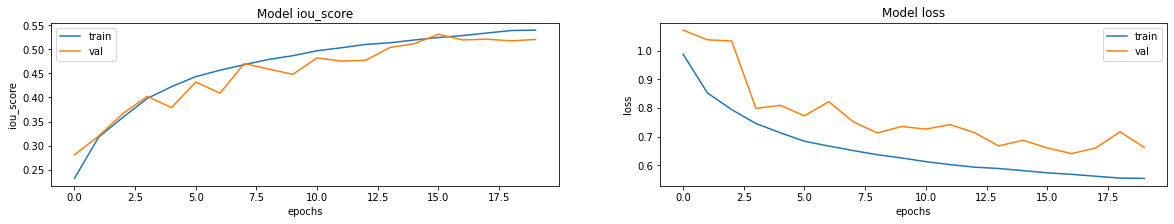

In [16]:
if not skip:
    if not trained:
        train_ds = get_dataset(train_df, augment=1)
        train_model(model, model_name, train_ds, val_ds)
    else:
        model.load_weights(f"./models/{model_name}_weights.h5")

    display_learning_curves(model_name, "iou_score")

./data/leftImg8bit/val/frankfurt/frankfurt_000001_051807_leftImg8bit.png


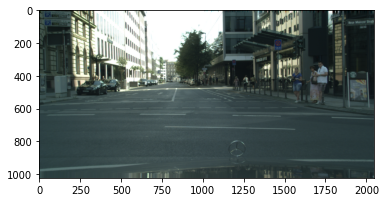

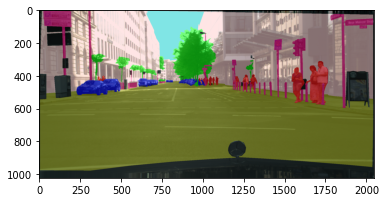

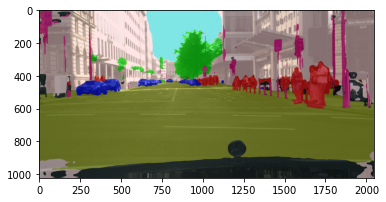

In [19]:
prediction_display(model, 180)

In [18]:
get_results()

          model_name  iou_score          time    loss
0  unet_resnet34_aug  0.5204     31134.051111  0.6619
